# Objectif:

Je veux faire marcher le code envoyé par François pour être sûr que j'ai toutes les bonnes dépendances.

Le problème principal était la fonction pour ouvrir des fichier image. François utilise PIL; je décide de changer et de m'appuyer sur PIMS; PIMS lui meme repose sur imageio pour ouvrir les .tif

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import trackpy as tp

In [46]:
# Le code de françois repose sur PIL ce qui n'est pas la meilleure dépendance..
# Je change avec la fonction en dessous pour utiliser PIMS

def francois_ouverture(file_path):
#file_path is the path of the movie
    #dataset contains the frames
    dataset = Image.open(file_path)
    #initialization: M is a list
    M = []
    for frame in ImageSequence.Iterator(dataset):
        M.append(np.array(dataset))
        #we add each frame as an array to the list    
    #conversion of the list into a 3D array: Nbframe x size of each frame
    M = np.array(M)
    return M


In [10]:
import pims

def ouverture(file_path):
    """ retourne les images d'un stack tiff comme un np.array(nframes, width, height)"""
    # WARNING: we should consider direcly using pims object instead of ndarrays!
    frames_list = []
    for frame in pims.TiffStack(file_path):
        frames_list.append(frame)
    return np.array(frames_list)

file_path = "/Users/benjaminhabert/Documents/FluotrackerProject/fluotracker/data/raw/movie8.tif"
frames = ouverture(file_path)
frames.shape

(231, 512, 512)

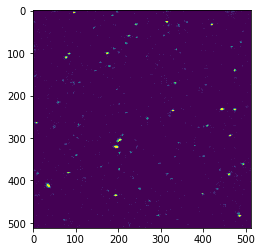

In [11]:
plt.imshow(frames[0])

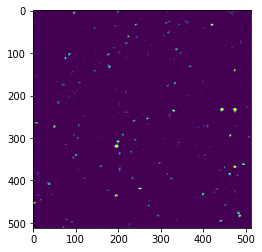

In [12]:
plt.imshow(frames[-1])

# Attention les yeux!

Frame 230: 136 trajectories present


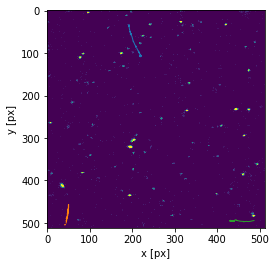


 3 trajectoires retenues

Trajectoire n° 1
Run Length = 1.775689844179105 +/- 0.9469185326186224 

Trajectoire n° 2
Run Length = 1.039149475144269 +/- 0.7706361805003964 

Trajectoire n° 3
Run Length = 2.240563974418045 +/- 1.2700633474164347 



In [13]:

# First step : open the tif file
filep = "/Users/benjaminhabert/Documents/FluotrackerProject/fluotracker/data/raw/movie8.tif"
frames = ouverture(filep)
Nbframe = frames.shape[0]
size = frames.shape[1]
pix=0.17    # in um; pixel size (0.0867 for TIRFx100)
dt=0.52877  # in s; exposure time (0.0545 s for TIRFx100)
Thres=4     # signal/noise;
CutOff=0.9  # in unit; confinement ratio cuf off for directed motion
Stop=0.3  # in µm; short stop
AngleC=70   # in deg; critical angle


# f contains the coordinates of all the bright spots in the frames
f = tp.batch(frames[:Nbframe], 11, minmass=50);
# t contains all the trajectories. search_range is the max displacement of the spot 
# between two frames in pixels, memory is the number of frames for which the spot
# can disappear
t = tp.link_df(f, search_range=10, memory=5)

# t_neurons will contain the trajectories of interest
t_neurons = pd.DataFrame()
Ntraj = 0
for item in set(t.particle):
    sub = t[t.particle==item] # selection of the item-th particle trajectory
    xmin,xmax = np.min(sub.x),np.max(sub.x)
    ymin,ymax = np.min(sub.y),np.max(sub.y)
    distance = np.sqrt((ymax-ymin)**2+(xmax-xmin)**2)
    # distance is an estimation of the particle displacement if the displacement
    # is roughly linear
    if distance>50:
        Ntraj += 1
        t_neurons = t_neurons.append(sub)
        
plt.figure()
plt.imshow(frames[0])
tp.plot_traj(t_neurons)

print('\n',Ntraj,'trajectoires retenues\n')

# temporary list to help with stats : data contains the values 
# from one frame to the next of Distance, time lag, velocity and the 
# identification of the particle
data = pd.DataFrame()
for item in set(t_neurons.particle):
    sub = t_neurons[t_neurons.particle==item]
    x,y = pix*sub.x,pix*sub.y
    dframe = np.diff(sub.frame)
    dx,dy = np.diff(x),np.diff(y)
    i = 0
    for p in set(sub.frame[:-1]):
        d = np.sqrt(dx[i]**2+dy[i]**2)
        Dt = dframe[i]*dt
        v = d/Dt
        if d<Stop:
            GO = -1 # if stop phase
        else:
            GO = +1 # if go phase
            
        data = data.append([{'distance': d,
                             'duree': Dt,
                             'vitesse': v,
                             'particle': item,
                             'frame': p,
                             'GO': GO
                            }]) 
        i += 1

Ntraj = 0
for item in set(data.particle):
    sub = data[data.particle==item]
    frame = np.array(sub.frame)
    distance = np.array(sub.distance)
    duree = np.array(sub.duree)
    vitesse = np.array(sub.vitesse)
    GO = np.array(sub.GO)
    Stops = [] # list containing the stop phase duration
    Processivities = []
    RunLength = []
    Velocities = []
    RL,ST, PT = 0,0,0 # initialization Run Length, Stop time, Processivity
    Ntraj += 1
    if GO[0]>0:
        RL += distance[0]
        PT += duree[0]
    else:
        ST += duree[0]
    for p in range(1,len(frame)):
        if GO[p]>0: # on incremente Run length et processivity
                    # on stocke la durée de la phase Stop
            RL += distance[p]
            PT += duree[p]
            if GO[p]*GO[p-1]<0: # on change de phase
                Stops.append(ST)
                ST = 0
        else:
            ST += duree[p]
            if GO[p]*GO[p-1]<0: # on change de phase
                V = RL/PT
                RunLength.append(RL)
                Processivities.append(PT)
                Velocities.append(V)
                RL,PT = 0,0
    RLaverage = np.average(RunLength)
    RLsigma = np.std(RunLength)
    
    print('Trajectoire n°',Ntraj)
    print('Run Length =',RLaverage,'+/-',RLsigma,'\n')
        